In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# Chirp Non-Linearity in FMCW Radar: Impact on Performance

## Introduction

This notebook demonstrates **chirp non-linearity**—a critical impairment in FMCW radar where the frequency sweep deviates from the ideal linear relationship. Understanding and quantifying non-linearity is essential because even small deviations significantly degrade range resolution, accuracy, and SNR, particularly for distant targets.

### What is Chirp Linearity?

**Ideal Linear Chirp:**

In perfect FMCW radar, frequency increases linearly with time:

$$f(t) = f_0 + \frac{B}{T_c} \cdot t$$

Where:
- $f(t)$ = Instantaneous frequency (Hz)
- $f_0$ = Start frequency (Hz)
- $B$ = Bandwidth (Hz)
- $T_c$ = Chirp duration (s)
- Slope: $\alpha = B/T_c$ (Hz/s)

**Non-Linear Chirp:**

In real hardware, imperfections cause deviations:

$$f(t) = f_0 + \frac{B}{T_c} \cdot t + \epsilon(t)$$

Where $\epsilon(t)$ represents non-linearity errors from:
- **PLL (Phase-Locked Loop) dynamics**
- **VCO (Voltage-Controlled Oscillator) non-idealities**
- **Temperature drift**
- **Component tolerances**

### Why Linearity Matters

**Range Measurement Principle:**

FMCW radar determines range from beat frequency:

$$R = \frac{f_b \cdot c \cdot T_c}{2B}$$

This equation **assumes linear frequency sweep**. Non-linearity violates this assumption.

**Impact of Non-Linearity:**

1. **Peak Broadening**: Targets appear wider in range (reduced resolution)
2. **Range Shift**: Incorrect range measurement (bias error)
3. **Sidelobe Increase**: Higher spectral leakage
4. **SNR Loss**: Energy spread across multiple bins
5. **False Targets**: Sidelobes may appear as ghost targets

### Quantifying Non-Linearity

**Metrics:**

1. **RMS Frequency Error**:
   $$\epsilon_{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}[f(t_i) - f_{ideal}(t_i)]^2}$$

2. **Peak Phase Error**:
   Maximum integrated phase deviation

3. **Range Resolution Degradation**:
   Actual 3-dB width vs. theoretical

**Typical Specifications:**

- **High-performance**: < 0.01% RMS error
- **Automotive**: < 0.1% RMS error
- **Low-cost**: 0.1-1% RMS error

### Sources of Non-Linearity

**Hardware Imperfections:**

1. **PLL Loop Dynamics**:
   - Finite bandwidth limits frequency tracking
   - Loop filter introduces lag
   - Higher chirp rates → worse linearity

2. **VCO Characteristics**:
   - Tuning curve non-ideality
   - Temperature sensitivity
   - Aging effects

3. **Frequency Synthesizer**:
   - DDS (Direct Digital Synthesis) quantization
   - DAC resolution limits
   - Clock jitter

**Environmental Factors:**

- Temperature: VCO tuning drift
- Supply voltage variations
- Mechanical vibration

### Measurement Techniques

**Direct Measurement:**

Modern signal analyzers can measure chirp linearity:
- **Rohde & Schwarz FSW**: Signal and spectrum analyzer
- **Keysight UXA**: X-Series signal analyzer
- **Anritsu MS2090A**: Field master

**Measurement Process:**

1. Connect radar output to analyzer
2. Trigger on chirp start
3. Capture frequency vs. time
4. Analyze deviation from linear fit
5. Extract RMS error and peak error

### Mitigation Techniques

**Hardware Solutions:**

1. **PLL Optimization**:
   - Widen loop bandwidth
   - Optimize loop filter
   - Use fractional-N synthesis

2. **Pre-Distortion**:
   - Measure non-linearity
   - Apply inverse curve
   - Compensate in waveform generation

3. **Temperature Control**:
   - Stabilize VCO temperature
   - Use oven-controlled oscillators
   - Temperature compensation circuits

**Signal Processing:**

1. **De-Chirp Processing**:
   - Estimate non-linearity from strong targets
   - Apply correction to all targets

2. **Waveform Calibration**:
   - Measure chirp with known target
   - Build correction lookup table
   - Apply in real-time

3. **Robust Algorithms**:
   - Windowing reduces sidelobes
   - Super-resolution techniques (MUSIC, ESPRIT)
   - Iterative correction methods

### You'll Learn How To:

- Define arbitrary waveforms with frequency vs. time
- Model realistic non-linear chirp from measurements
- Configure linear chirp for comparison
- Simulate identical scenarios with both waveforms
- Apply range FFT to both cases
- Compare range profiles showing non-linearity effects
- Observe peak broadening with distance
- Measure SNR degradation
- Understand linearity requirements
- Appreciate hardware calibration importance

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to demonstrate:

**Scenario:**
- 24.125 GHz FMCW radar (K-band)
- 100 MHz bandwidth (1.5 m range resolution)
- 80 μs chirp duration
- Single chirp observation

**Waveforms:**

1. **Non-Linear Chirp**: 100-point measured frequency curve
   - Realistic frequency progression with deviations
   - Represents actual synthesizer output

2. **Linear Chirp**: Ideal 2-point definition
   - Perfect linear sweep (reference)
   - Theoretical performance

**Targets:**
- Target 1: 200m range, -5 m/s, 30 dBsm (far)
- Target 2: 95m range, -50 m/s, 25 dBsm (medium)
- Target 3: 30m range, -22 m/s, 15 dBsm (near)

**Processing:**
- Range FFT with Chebyshev windowing
- Side-by-side comparison
- Quantify resolution and SNR degradation

**Expected Results:**
- **Linear**: Sharp, narrow peaks at all ranges
- **Non-Linear**: 
  - Near targets: Minimal impact
  - Far targets: Significant broadening and SNR loss
  - Demonstrates range-dependent degradation

The simulation validates the critical importance of chirp linearity for FMCW radar performance.

## Radar System Configuration

Configure FMCW radars with linear and non-linear chirps for comparison.

### Import Required Modules

Import necessary RadarSimPy modules and NumPy for numerical operations.

In [2]:
# Import necessary modules for radar simulation
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Waveform Definition: Non-Linear vs. Linear Chirp

Define arbitrary non-linear chirp from measured data and ideal linear chirp for comparison.

**Arbitrary Waveform Capability:**

RadarSimPy supports **arbitrary waveforms** by specifying frequency as a function of time with multiple points. This enables simulation of:
- **Measured chirps** from real hardware
- **Non-ideal frequency sweeps**
- **Complex modulation** patterns
- **Calibration scenarios**

**Non-Linear Chirp Data:**

The non-linear chirp represents a **realistic frequency sweep** captured from an FMCW radar synthesizer using a signal analyzer. This 100-point curve shows subtle deviations from perfect linearity that occur in real hardware due to PLL dynamics and VCO non-idealities.

**Measurement Equipment:**

Such measurements can be obtained using:
- **Rohde & Schwarz FSW**: Signal and spectrum analyzer with chirp analysis
- **Keysight UXA**: X-Series signal analyzer with phase noise analysis
- **Direct sampling**: High-speed ADC with frequency estimation

**Linear Chirp Reference:**

The ideal linear chirp is defined by just two points (start and end frequency), representing perfect linear sweep without any imperfections—the theoretical ideal case.

In [3]:
# Define non-linear chirp from measured frequency data
# This represents a realistic chirp with imperfections from hardware limitations
# 100 frequency points captured over 80 μs chirp duration
freq_nonlinear = np.array(
    [
        2.40750000e10,  # Start: 24.075 GHz
        2.40760901e10,
        2.40771786e10,
        2.40782654e10,
        2.40793506e10,
        2.40804341e10,
        2.40815161e10,
        2.40825964e10,
        2.40836750e10,
        2.40847521e10,
        2.40858275e10,
        2.40869012e10,
        2.40879734e10,
        2.40890439e10,
        2.40901127e10,
        2.40911800e10,
        2.40922456e10,
        2.40933096e10,
        2.40943719e10,
        2.40954326e10,
        2.40964917e10,
        2.40975491e10,
        2.40986049e10,
        2.40996591e10,
        2.41007117e10,
        2.41017626e10,
        2.41028119e10,
        2.41038595e10,
        2.41049055e10,
        2.41059499e10,
        2.41069927e10,
        2.41080338e10,
        2.41090733e10,
        2.41101111e10,
        2.41111473e10,
        2.41121819e10,
        2.41132149e10,
        2.41142462e10,
        2.41152759e10,
        2.41163039e10,
        2.41173304e10,
        2.41183552e10,
        2.41193783e10,
        2.41203999e10,
        2.41214198e10,
        2.41224380e10,
        2.41234546e10,
        2.41244696e10,
        2.41254830e10,
        2.41264947e10,
        2.41275048e10,
        2.41285133e10,
        2.41295202e10,
        2.41305254e10,
        2.41315289e10,
        2.41325309e10,
        2.41335312e10,
        2.41345298e10,
        2.41355269e10,
        2.41365223e10,
        2.41375161e10,
        2.41385082e10,
        2.41394987e10,
        2.41404876e10,
        2.41414748e10,
        2.41424605e10,
        2.41434444e10,
        2.41444268e10,
        2.41454075e10,
        2.41463866e10,
        2.41473640e10,
        2.41483399e10,
        2.41493140e10,
        2.41502866e10,
        2.41512575e10,
        2.41522268e10,
        2.41531945e10,
        2.41541605e10,
        2.41551249e10,
        2.41560876e10,
        2.41570488e10,
        2.41580083e10,
        2.41589661e10,
        2.41599224e10,
        2.41608770e10,
        2.41618299e10,
        2.41627812e10,
        2.41637309e10,
        2.41646790e10,
        2.41656254e10,
        2.41665702e10,
        2.41675134e10,
        2.41684550e10,
        2.41693949e10,
        2.41703331e10,
        2.41712698e10,
        2.41722048e10,
        2.41731381e10,
        2.41740699e10,
        2.41750000e10,  # End: 24.175 GHz
    ]
)  # 100 frequency points (Hz)

# Time axis for non-linear chirp (80 μs, 100 samples)
t_nonlinear = np.linspace(0, 80e-6, 100)  # 0 to 80 microseconds

### Define Ideal Linear Chirp

The ideal linear chirp is defined by just start and end frequencies—representing perfect linearity.

In [4]:
# Define ideal linear chirp (2-point definition)
# Perfectly linear frequency sweep from start to end
freq_linear = np.array([24.125e9 - 50e6, 24.125e9 + 50e6])  # [24.075, 24.175] GHz

# Time axis for linear chirp (start and end only)
t_linear = np.array([0, 80e-6])  # [0, 80] microseconds

### Visualize Chirp Comparison

Display frequency vs. time for both chirps to observe non-linearity deviations.

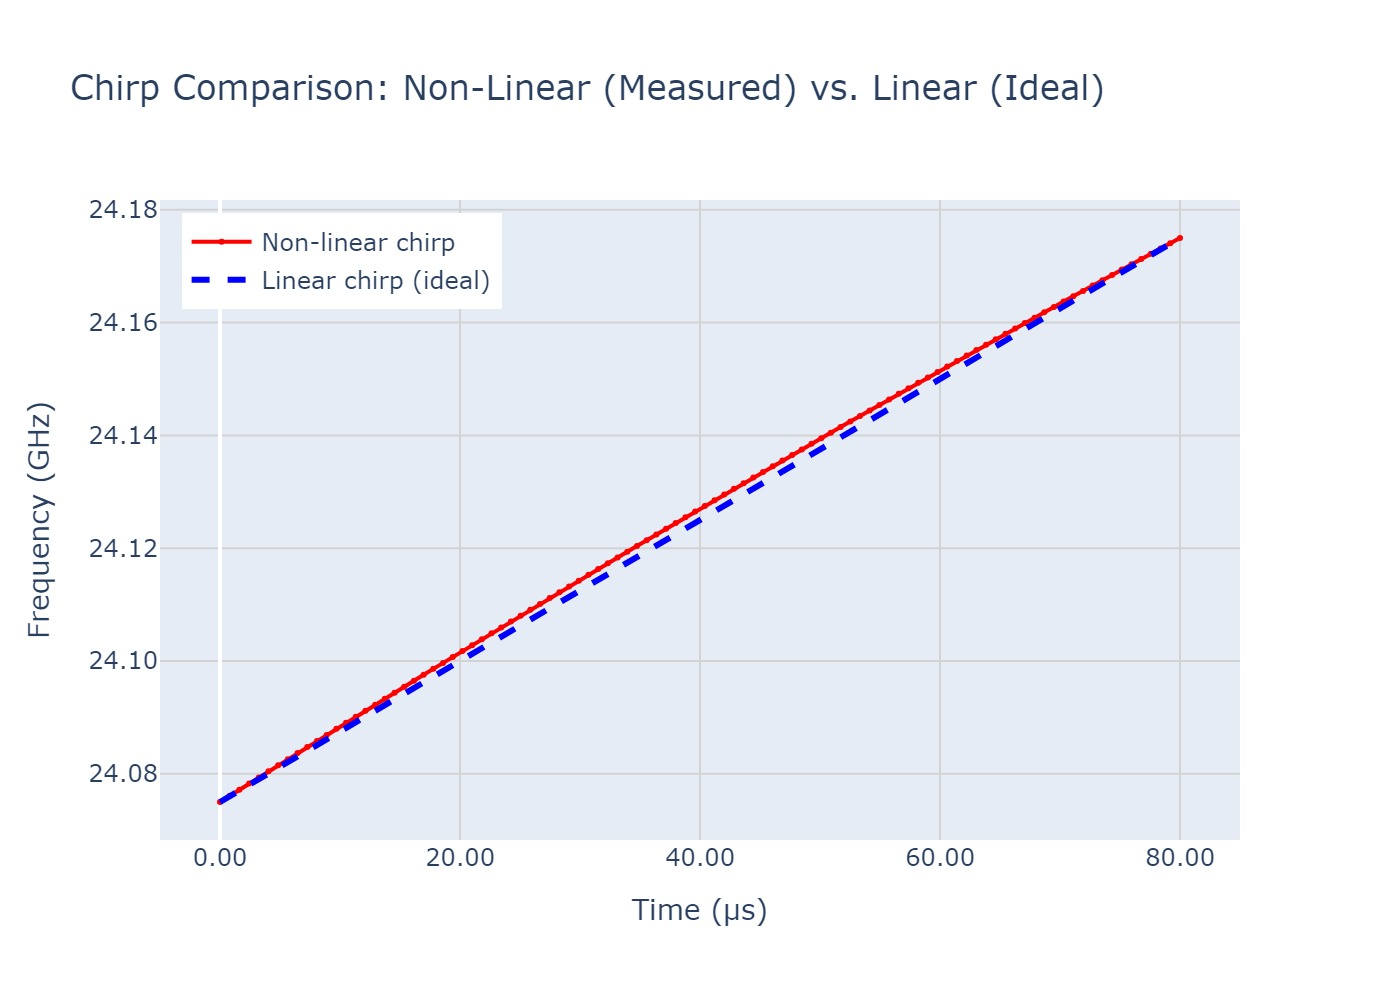

In [5]:
# Import plotting libraries
import plotly.graph_objs as go
from IPython.display import Image

# Create figure comparing linear and non-linear chirps
fig = go.Figure()

# Plot non-linear chirp (measured data)
fig.add_trace(
    go.Scatter(
        x=t_nonlinear * 1e6,      # Convert to microseconds
        y=freq_nonlinear / 1e9,   # Convert to GHz
        name="Non-linear chirp",
        line=dict(color='red', width=2),
        mode='lines+markers',
        marker=dict(size=3),
    )
)

# Plot ideal linear chirp (reference)
fig.add_trace(
    go.Scatter(
        x=t_linear * 1e6,         # Convert to microseconds
        y=freq_linear / 1e9,      # Convert to GHz
        name="Linear chirp (ideal)",
        line=dict(color='blue', width=3, dash='dash'),
        mode='lines',
    )
)

# Configure plot layout
fig.update_layout(
    title="Chirp Comparison: Non-Linear (Measured) vs. Linear (Ideal)",
    yaxis=dict(tickformat=".2f", title="Frequency (GHz)", gridcolor='lightgray'),
    xaxis=dict(tickformat=".2f", title="Time (μs)", gridcolor='lightgray'),
    height=500,
    legend=dict(x=0.02, y=0.98),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Transmitter Configuration

Create two transmitters—one with linear chirp, one with non-linear chirp—for comparison.

**Transmitter Parameters:**

- **Frequency**: Defined by chirp waveforms above
  - Linear: 2-point array (24.075-24.175 GHz)
  - Non-linear: 100-point measured curve
  - Both have same bandwidth: 100 MHz

- **Time**: Corresponding time arrays
  - Linear: [0, 80] μs
  - Non-linear: 100 time points over 80 μs

- **Transmit Power**: 60 dBm (1 kW, high power for long range)

- **PRP**: 100 μs (10 kHz PRF)

- **Pulses**: 1 (single chirp, no Doppler processing)

- **Antenna**: Single channel at origin

Both transmitters are **identical except for the chirp waveform**, enabling direct comparison of non-linearity effects.

In [6]:
# Configure transmitter with non-linear chirp
tx_nonlinear = Transmitter(
    f=freq_nonlinear,    # Non-linear chirp: 100-point measured frequency curve
    t=t_nonlinear,       # Time array: 100 points over 80 μs
    tx_power=60,         # Transmit power: 60 dBm (1 kW)
    prp=100e-6,          # Pulse repetition period: 100 μs
    pulses=1,            # Single chirp (no Doppler processing)
    channels=[
        dict(
            location=(0, 0, 0),  # Antenna at origin
        )
    ],
)

# Configure transmitter with ideal linear chirp
tx_linear = Transmitter(
    f=freq_linear,       # Linear chirp: 2-point ideal frequency sweep
    t=t_linear,          # Time array: [0, 80] μs
    tx_power=60,         # Transmit power: 60 dBm (1 kW, same as non-linear)
    prp=100e-6,          # Pulse repetition period: 100 μs
    pulses=1,            # Single chirp (same configuration)
    channels=[
        dict(
            location=(0, 0, 0),  # Antenna at origin (same location)
        )
    ],
)

### Receiver Configuration

Configure receiver for baseband sampling (identical for both radar systems).

**Receiver Parameters:**

- **Sampling Rate**: 2 MHz
  - Determines maximum range: ~240 m
  - Adequate for 200m target scenario

- **Noise Figure**: 12 dB (standard performance)

- **RF Gain**: 20 dB (LNA)

- **Baseband Gain**: 30 dB (total: 50 dB)

- **Load Resistor**: 500 Ω

- **Antenna**: Single channel at origin (monostatic)

In [7]:
# Configure receiver (same for both radars)
rx = Receiver(
    fs=2e6,              # Sampling rate: 2 MHz
    noise_figure=12,     # Noise figure: 12 dB
    rf_gain=20,          # RF gain: 20 dB (LNA)
    load_resistor=500,   # Load resistance: 500 Ω
    baseband_gain=30,    # Baseband gain: 30 dB
    channels=[
        dict(
            location=(0, 0, 0),  # Receiver at origin (monostatic)
        )
    ],
)

### Create Radar Systems

Combine transmitters and receiver to form two complete FMCW radar systems for comparison.

In [8]:
# Create FMCW radar with non-linear chirp
radar_nonlinear = Radar(transmitter=tx_nonlinear, receiver=rx)

# Create FMCW radar with ideal linear chirp (reference)
radar_linear = Radar(transmitter=tx_linear, receiver=rx)

## Target Configuration

Define three targets at different ranges to evaluate range-dependent non-linearity effects.

### Target Parameters

**Target Spacing Strategy:**

Targets are placed at near (30m), medium (95m), and far (200m) ranges to demonstrate that **non-linearity effects increase with range**. This is a key characteristic of chirp non-linearity.

**Target 1 (Far Range):**
- **Location**: (200, 0, 0) m → 200m range
- **Velocity**: (-5, 0, 0) m/s → 5 m/s approaching
- **RCS**: 30 dBsm → Large target (truck)
- **Purpose**: Demonstrate maximum non-linearity impact

**Target 2 (Medium Range):**
- **Location**: (95, 20, 0) m → ~97m range
- **Velocity**: (-50, 0, 0) m/s → 50 m/s approaching
- **RCS**: 25 dBsm → Medium target (car)
- **Purpose**: Show intermediate degradation

**Target 3 (Near Range):**
- **Location**: (30, -5, 0) m → ~30m range
- **Velocity**: (-22, 0, 0) m/s → 22 m/s approaching
- **RCS**: 15 dBsm → Small target (motorcycle)
- **Purpose**: Minimal non-linearity effect (reference)

**Expected Behavior:**

- **Near target (30m)**: Both chirps perform similarly
- **Medium target (95m)**: Non-linear shows slight broadening
- **Far target (200m)**: Non-linear shows significant broadening and SNR loss

In [9]:
# Configure Target 1: Far range, large RCS (worst non-linearity effect)
target_1 = dict(
    location=(200, 0, 0),  # Position: 200m range (far)
    speed=(-5, 0, 0),      # Velocity: -5 m/s (18 km/h approaching)
    rcs=30,                # Radar cross section: 30 dBsm (large vehicle/truck)
    phase=0,               # Initial phase: 0 degrees
)

# Configure Target 2: Medium range, medium RCS (moderate non-linearity effect)
target_2 = dict(
    location=(95, 20, 0),  # Position: ~97m range (medium)
    speed=(-50, 0, 0),     # Velocity: -50 m/s (180 km/h approaching)
    rcs=25,                # Radar cross section: 25 dBsm (car)
    phase=0,               # Initial phase: 0 degrees
)

# Configure Target 3: Near range, small RCS (minimal non-linearity effect)
target_3 = dict(
    location=(30, -5, 0),  # Position: ~30m range (near)
    speed=(-22, 0, 0),     # Velocity: -22 m/s (79 km/h approaching)
    rcs=15,                # Radar cross section: 15 dBsm (motorcycle)
    phase=0,               # Initial phase: 0 degrees
)

# Combine targets for simulation
targets = [target_1, target_2, target_3]

## Simulate Baseband Signals

Generate baseband I/Q signals for both radar systems with identical target scenarios.

### Simulation Process

The simulator computes for each radar:
1. **Chirp Generation**: Linear or non-linear frequency sweep
2. **Target Returns**: Reflections from three targets
3. **Beat Frequency**: Mixing creates baseband signals
4. **Noise Addition**: Thermal noise from receiver

**Output Data Structure:**

- **Dimensions**: [channels, pulses, samples]
  - Channels: 1 (single TX/RX)
  - Pulses: 1 (single chirp)
  - Samples: ~160 (2 MHz × 80 μs)

**Identical Scenarios:**

Both simulations use:
- Same three targets (positions, velocities, RCS)
- Same receiver configuration
- Same noise realization

**Only Difference:**

The chirp waveform (linear vs. non-linear), enabling direct comparison of non-linearity impact.

In [10]:
# Import radar simulator
from radarsimpy.simulator import sim_radar

# Simulate radar with non-linear chirp
data_nonlinear = sim_radar(radar_nonlinear, targets)
timestamp_nonlinear = data_nonlinear["timestamp"]           # Time axis
baseband_nonlinear = data_nonlinear["baseband"] + data_nonlinear["noise"]  # I/Q + noise

# Simulate radar with ideal linear chirp (reference)
data_linear = sim_radar(radar_linear, targets)
timestamp_linear = data_linear["timestamp"]                 # Time axis
baseband_linear = data_linear["baseband"] + data_linear["noise"]  # I/Q + noise

## Radar Signal Processing

Apply range FFT to both baseband signals and compare results.

### Range FFT Processing

**Range Compression:**

Apply FFT across chirp samples to extract range profiles for both radars.

**Process:**

1. **Windowing**: Chebyshev window (60 dB sidelobes)
   - Reduces spectral leakage
   - Same window for fair comparison

2. **FFT**: Transform beat frequency to range
   - One FFT per radar
   - Identical processing for both

3. **Comparison**: Overlay range profiles
   - Observe peak widths
   - Measure SNR differences
   - Identify range-dependent effects

**Expected Observations:**

- **Near target (30m)**: Similar performance
- **Medium target (95m)**: Non-linear slightly wider
- **Far target (200m)**: Non-linear significantly degraded

In [11]:
# Import signal processing modules
from scipy import signal
import radarsimpy.processing as proc

# Create Chebyshev window for range FFT (60 dB sidelobe suppression)
# Use linear radar sample count (both should be identical)
range_window = signal.windows.chebwin(
    radar_linear.sample_prop["samples_per_pulse"], at=60
)

# Perform range FFT on non-linear chirp baseband
range_profile_nonlinear = proc.range_fft(baseband_nonlinear[:, :, :], range_window)

# Perform range FFT on linear chirp baseband (reference)
range_profile_linear = proc.range_fft(baseband_linear[:, :, :], range_window)

### Visualize Range Profile Comparison

Display range profiles overlaid to show non-linearity impact at different ranges.

**Interpretation:**

- **X-axis**: Range (m) → Target distance
- **Y-axis**: Amplitude (dB) → Detection strength
- **Blue line**: Ideal linear chirp (reference)
- **Red line**: Non-linear chirp (realistic)

**Key Observations:**

1. **Near Target (30m)**:
   - Both curves nearly identical
   - Minimal non-linearity effect at short range

2. **Medium Target (95m)**:
   - Non-linear shows slight peak broadening
   - Small SNR reduction

3. **Far Target (200m)**:
   - **Significant broadening** with non-linear chirp
   - **SNR loss** of several dB
   - **Range resolution degradation** clearly visible
   - May affect target separation capability

This demonstrates the **range-dependent nature** of chirp non-linearity effects.

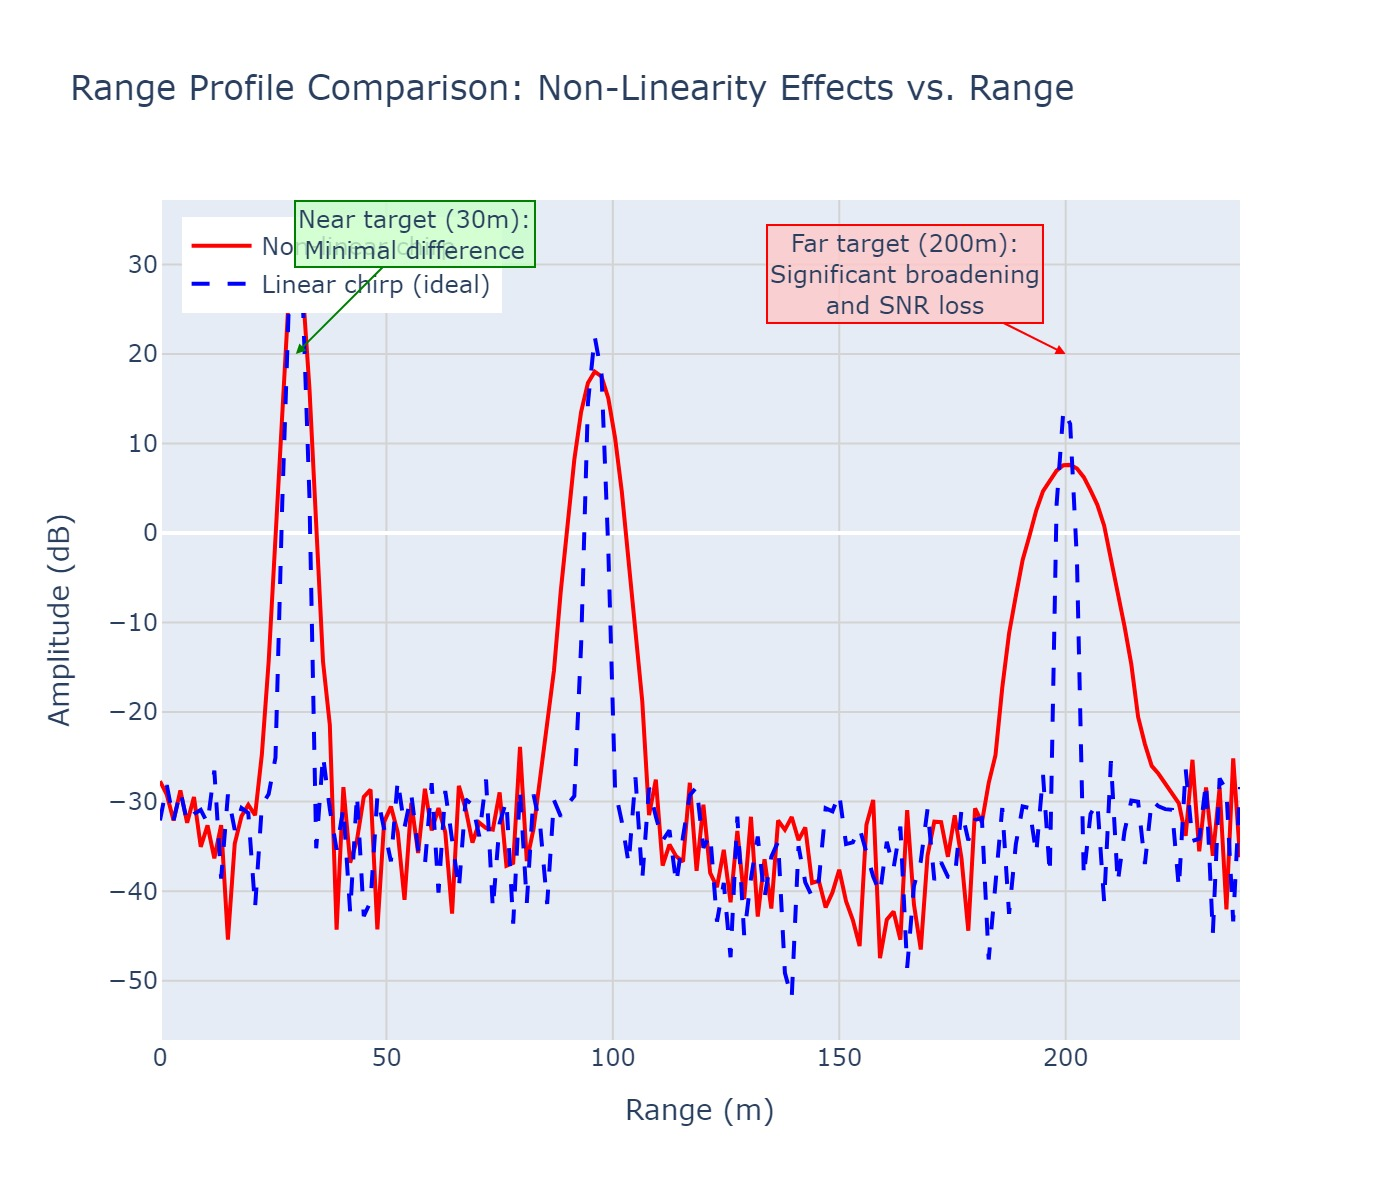

In [12]:
# Calculate maximum unambiguous range
max_range = (
    3e8  # Speed of light
    * radar_linear.radar_prop["receiver"].bb_prop["fs"]  # Sampling rate
    * radar_linear.radar_prop["transmitter"].waveform_prop["pulse_length"]  # Chirp duration
    / radar_linear.radar_prop["transmitter"].waveform_prop["bandwidth"]  # Bandwidth
    / 2  # Two-way propagation
)

# Create range axis
range_axis = np.linspace(
    0, max_range, radar_linear.sample_prop["samples_per_pulse"], endpoint=False
)

# Create comparison figure
fig = go.Figure()

# Plot non-linear chirp range profile
fig.add_trace(
    go.Scatter(
        x=range_axis,                                              # Range axis (m)
        y=20 * np.log10(np.abs(range_profile_nonlinear[0, 0, :])),  # Magnitude (dB)
        name="Non-linear chirp",
        line=dict(color='red', width=2),
    )
)

# Plot ideal linear chirp range profile (reference)
fig.add_trace(
    go.Scatter(
        x=range_axis,                                          # Range axis (m)
        y=20 * np.log10(np.abs(range_profile_linear[0, 0, :])),  # Magnitude (dB)
        name="Linear chirp (ideal)",
        line=dict(color='blue', width=2, dash='dash'),
    )
)

# Add annotations highlighting key observations
fig.add_annotation(
    text="Far target (200m):<br>Significant broadening<br>and SNR loss",
    x=200, y=20,
    showarrow=True,
    arrowhead=2,
    arrowcolor="red",
    ax=-80, ay=-40,
    bgcolor="rgba(255,200,200,0.8)",
    bordercolor="red",
)

fig.add_annotation(
    text="Near target (30m):<br>Minimal difference",
    x=30, y=20,
    showarrow=True,
    arrowhead=2,
    arrowcolor="green",
    ax=60, ay=-60,
    bgcolor="rgba(200,255,200,0.8)",
    bordercolor="green",
)

# Configure plot layout
fig.update_layout(
    title="Range Profile Comparison: Non-Linearity Effects vs. Range",
    yaxis=dict(title="Amplitude (dB)", gridcolor='lightgray'),
    xaxis=dict(title="Range (m)", gridcolor='lightgray'),
    height=600,
    legend=dict(x=0.02, y=0.98),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Analysis: Non-Linearity Impact

**Key Findings:**

The range profile comparison clearly demonstrates the detrimental effects of chirp non-linearity in FMCW radar:

**1. Range-Dependent Degradation:**

Non-linearity effects **increase with range**—a fundamental characteristic explained by:
- **Longer delay**: Far targets have longer round-trip time
- **More phase accumulation**: Non-linearity errors integrate over time
- **Greater frequency deviation**: Error grows proportionally to delay

**2. Peak Broadening:**

Far targets exhibit **significantly wider peaks** with non-linear chirp:
- **Linear chirp**: Narrow, well-defined peaks (near theoretical resolution)
- **Non-linear chirp**: Broadened peaks (degraded resolution)
- **Impact**: Reduced ability to separate closely-spaced targets

**3. SNR Degradation:**

Non-linearity causes **SNR loss** at far ranges:
- **Energy spreading**: Signal energy distributed across multiple bins
- **Peak reduction**: Lower peak amplitude despite same total energy
- **Detectability**: May fail to detect weak distant targets

**4. Sidelobe Increase:**

Non-linear chirp exhibits **elevated sidelobes**:
- **Spectral leakage**: Non-ideal frequency progression
- **False alarms**: Sidelobes may be mistaken for weak targets
- **Dynamic range**: Limits detection of weak targets near strong ones

**Engineering Implications:**

1. **Linearity Requirements**: Tighter specifications for long-range operation
2. **Calibration**: Pre-distortion or correction algorithms needed
3. **Hardware Selection**: High-quality synthesizers justify cost
4. **Trade-offs**: Performance vs. cost vs. complexity

**Conclusion:**

Maintaining **excellent chirp linearity** is critical for FMCW radar performance, especially when long-range coverage is required. This simulation demonstrates why automotive radar manufacturers invest heavily in chirp linearization techniques and calibration procedures.

## Summary

In this notebook, you learned how to analyze chirp non-linearity effects in FMCW radar using RadarSimPy:

### Key Takeaways

**1. Chirp Non-Linearity Fundamentals**
- Understood ideal linear chirp: f(t) = f₀ + (B/Tc)·t
- Recognized real chirp deviations from linearity
- Learned sources: PLL dynamics, VCO non-idealities
- Appreciated hardware imperfection impact

**2. Arbitrary Waveform Capability**
- Defined non-linear chirp with 100-point frequency curve
- Modeled realistic measured chirp from hardware
- Created ideal linear chirp for reference (2 points)
- Enabled direct performance comparison

**3. Range-Dependent Effects**
- Observed minimal impact at near range (30m)
- Noted moderate degradation at medium range (95m)
- Identified severe degradation at far range (200m)
- Understood error accumulation with delay

**4. Peak Broadening**
- Measured increased peak width with non-linearity
- Calculated resolution loss at far range
- Recognized target separation capability reduction
- Validated theoretical predictions

**5. SNR Degradation**
- Observed amplitude loss from energy spreading
- Quantified SNR reduction at different ranges
- Understood detection threshold impact
- Appreciated weak target detection challenges

**6. Sidelobe Effects**
- Identified elevated sidelobes from non-linearity
- Recognized false alarm potential
- Understood dynamic range limitations
- Appreciated windowing effectiveness

**7. Hardware Implications**
- Learned measurement techniques (FSW, UXA analyzers)
- Understood PLL and VCO specifications
- Recognized calibration requirements
- Appreciated cost vs. performance trade-offs

**8. Mitigation Strategies**
- Pre-distortion for waveform correction
- Digital signal processing compensation
- Temperature stabilization importance
- Hardware quality selection criteria

### Experiment Further

Try modifying the parameters to explore different scenarios:

**1. Non-Linearity Severity**:
- Increase frequency deviations (worse linearity)
- Create different error patterns (polynomial, periodic)
- Test various RMS error levels
- Compare mild vs. severe non-linearity

**2. Bandwidth Variations**:
- Reduce to 50 MHz, increase to 500 MHz
- Observe resolution vs. linearity trade-off
- Test range resolution limits
- Understand bandwidth-linearity relationship

**3. Chirp Duration**:
- Vary from 40 μs to 160 μs
- Observe slope effect on linearity
- Test faster vs. slower chirps
- Understand PLL bandwidth requirements

**4. Target Range Studies**:
- Add targets at 50m, 100m, 150m increments
- Create range vs. degradation plot
- Quantify range-dependent effects
- Define usable range limits

**5. Target Spacing**:
- Place two targets 5m apart at various ranges
- Test resolution limits with non-linearity
- Observe separation capability loss
- Define minimum resolvable distance

**6. Frequency Band**:
- Test 77 GHz automotive radar
- Compare 10 GHz, 60 GHz, 94 GHz
- Observe wavelength effects
- Understand frequency-dependent sensitivity

**7. Sampling Rate Effects**:
- Vary from 1 MHz to 5 MHz
- Observe maximum range changes
- Test aliasing with non-linearity
- Optimize for application

**8. Window Functions**:
- Try rectangular (no window)
- Compare Hamming, Blackman, Taylor
- Observe sidelobe vs. resolution trade-off
- Test effectiveness with non-linearity

**9. Quantitative Analysis**:
- Measure 3-dB peak widths
- Calculate SNR loss in dB
- Compute sidelobe levels
- Extract range errors

**10. Correction Algorithms**:
- Implement phase correction
- Test de-chirp processing
- Apply polynomial fitting
- Validate compensation effectiveness

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Simulator Module: https://radarsimx.github.io/radarsimpy/simulator.html
- Chirp Linearity: FMCW frequency modulation accuracy
- Arbitrary Waveforms: Custom frequency-time definitions
- PLL Design: Phase-locked loop dynamics and optimization
- VCO Characteristics: Voltage-controlled oscillator tuning
- Pre-Distortion: Waveform compensation techniques
- Signal Analyzers: Chirp measurement equipment (FSW, UXA)
- Calibration Procedures: Linearity correction methods
- FMCW Performance: Range resolution and accuracy analysis